In [ ]:
# install for bert 
! pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# we shall follow tutorial to build LSTM through this link
# https://towardsdatascience.com/sentiment-analysis-using-lstm-step-by-step-50d074f09948
# bert usage through this link
# https://www.kaggle.com/code/chayan8/sentiment-analysis-using-bert-pytorch#3.-Loading-Tokenizer-and-Encoding-our-Data

import pandas as pd
import seaborn as sns
import torch 
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import PorterStemmer
from string import punctuation
import numpy as np 
from transformers import BertForSequenceClassification
from transformers import BertTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import f1_score
import random
from tqdm.notebook import tqdm

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve
from sklearn import preprocessing
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


In [ ]:
# TRAIN ON GPU DEFINITION
# JUST REMOVE THIS AND CHANGE TO FALSE IF U DONT WANT TO CHECK WITH TORCH
train_on_gpu = True if torch.cuda.is_available() else False


In [ ]:
# seeding everything for replication 
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Download and define necessary constants

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

torch.device("cuda")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


device(type='cuda')

In [ ]:
STOPWORDS_ENG = set(stopwords.words('english')) 
PORTER_STEMMER = PorterStemmer()
PUNCTUATIONS_TO_REMOVED = punctuation

In [ ]:
df = pd.read_table('Sentiment140.tenPercent.sample.tweets.tsv')

In [ ]:
df.head()

,sentiment_label,tweet_text
0,4,"@elephantbird Hey dear, Happy Friday to You A..."
1,4,Ughhh layin downnnn Waiting for zeina to co...
2,0,"@greeniebach I reckon he'll play, even if he's..."
3,0,@vaLewee I know! Saw it on the news!
4,0,very sad that http://www.fabchannel.com/ has c...


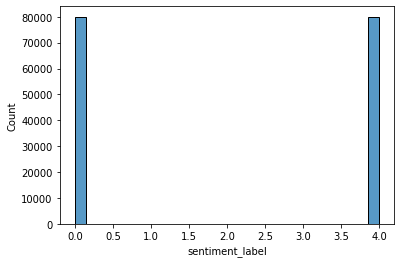

In [ ]:
# check label distribution
# equal label dataset on sentiment
# seems like for this assignment, 2 has been taken out
# only negative (0) and positive labels are left (4)
sns.histplot(data=df, x="sentiment_label")

# Preprocessing 

We create 2 datasets: raw and cleaned

for raw we perform following operations: lowerstring and tokenization

for cleaned we perform following additional  operations from raw: remove punctuations and stop words. 

We then plot boxplot for the number of tokens for each dataset. this is so we can accurately obtain the string length for the input of our model 

As we can see, there are rows that only have either punctuation or stop words, therefore we shall remove those rows with this characteristic for both dataset (Maybe more extreme strings can be removed (like 103 length) but currently we keep it as is.)

Then we plot the boxplot and describe the cleaned dataframe. 

Finally we select 124 as our string length because it is more than the max and is a number that is a result of power of 2.

Lastly for preprocessing, we pad the tokens to finally have the length of 124 with a token item. 

In [ ]:
# preprocessing and tokenization on tweet_text column for it to be suitable for analysis
from typing import List

def lower_string(x: str):
  return x.lower() if x is not None else x

def remove_punctuation(tokens, punctuations=PUNCTUATIONS_TO_REMOVED):
  return [w for w in tokens if not w in punctuations] 

def remove_stop_words(tokens, stopwords=STOPWORDS_ENG):
  return [w for w in tokens if not w in stopwords] 

def tokenization(x: str) -> List[str]:
  return word_tokenize(x)

df['tweet_lowered'] = df['tweet_text'].apply(lower_string)
df['tweet_processed_raw'] = df['tweet_lowered'].apply(tokenization)
# df['sentiment_label'] = df['sentiment_label'].apply(relabel) 
df['tweet_processed_cleaned'] = df['tweet_processed_raw'].apply(remove_punctuation)
df['tweet_processed_cleaned'] = df['tweet_processed_cleaned'].apply(remove_stop_words)


,tweet_processed_raw_len,tweet_processed_cleaned_len
count,160000.000000,160000.000000
mean,16.417069,8.383269
std,8.561186,4.363839
min,1.000000,0.000000
25%,9.000000,5.000000
50%,15.000000,8.000000
75%,23.000000,11.000000
max,103.000000,53.000000


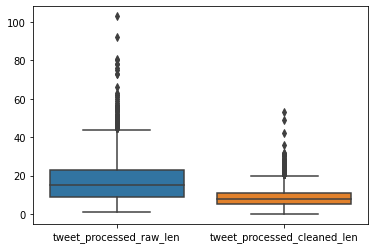

In [ ]:
df['tweet_processed_raw_len']  = df['tweet_processed_raw'].apply(len)
df['tweet_processed_cleaned_len']  = df['tweet_processed_cleaned'].apply(len)
display(df[['tweet_processed_raw_len', 'tweet_processed_cleaned_len']].describe())
sns.boxplot(data=df[['tweet_processed_raw_len', 'tweet_processed_cleaned_len']])

In [ ]:
def is_empty(x: int) -> bool:
  return x == 0

ready_df = df[~df['tweet_processed_cleaned_len'].apply(is_empty)]
ready_df = ready_df[~ready_df['tweet_processed_raw_len'].apply(is_empty)]

,tweet_processed_raw_len,tweet_processed_cleaned_len
count,159978.000000,159978.000000
mean,16.418720,8.384422
std,8.560319,4.363032
min,1.000000,1.000000
25%,9.000000,5.000000
50%,15.000000,8.000000
75%,23.000000,11.000000
max,103.000000,53.000000


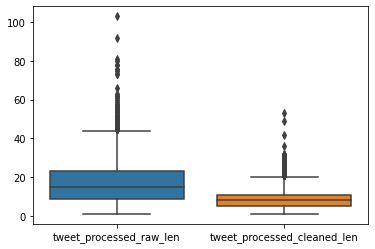

In [ ]:
# result from after cleaning 
# 22 rows were removed. 
display(ready_df[['tweet_processed_raw_len', 'tweet_processed_cleaned_len']].describe())
sns.boxplot(data=ready_df[['tweet_processed_raw_len', 'tweet_processed_cleaned_len']])

In [ ]:
# sns.histplot(data=ready_df, x="sentiment_label")
display(df['sentiment_label'].value_counts())
display(ready_df['sentiment_label'].value_counts())

4    80000
0    80000
Name: sentiment_label, dtype: int64

0    79992
4    79986
Name: sentiment_label, dtype: int64

In [ ]:
SEQ_LENGTH = 25

# Train test 
we want our encoder to not cheat and know vocab that is out of training data therefore we need to perform train test split here

In [ ]:
from sklearn.model_selection import train_test_split


In [ ]:
train_df, test_df = train_test_split(ready_df, test_size=0.20, random_state=42)
test_df, val_df = train_test_split(test_df, test_size=0.5, random_state=42)

## Vocab generation: cleaned version 

here we generate word to int mapping 

this can be done by counting word and assigning higher count word to lower value or we could use an NN based embedding to do it.

Essentially pytorch doesn't have a supporting Tokenizer like keras so we have to do mapping on our own, what we are doing is similar to what Sepinoud did in her example with keras

In [ ]:
dataset_column = 'tweet_processed_cleaned'
label_column = 'sentiment_label'
# x and y columns are for columns that should be processed and ready for training 
x_column = 'x' 
y_column = 'y'

In [ ]:
from collections import Counter

OOV_VAL = 1
PAD_VAL = 0

def df_to_vocab_dict(df, column):
  # create a list of words
  words = df[dataset_column].explode()
  # Count all the words using Counter Method
  count_words = Counter(words)
  total_words = len(words)
  sorted_words = count_words.most_common(total_words)
  vocab_to_int = {w:i+2 for i, (w,c) in enumerate(sorted_words)}
  # print(count_words)
  return vocab_to_int

def encode_words(words, vocab_dict, OOV=OOV_VAL):
  return [vocab_dict[w] if w in vocab_dict.keys() else OOV for w in words]


def encode_words_series(df, column, vocab_dict, OOV=OOV_VAL):
  """
  encode word to its vocab values
  out of vocab is -1
  mask should be -2 --> it should be different from oov
  """
  return df[column].apply(lambda x: encode_words(x, vocab_dict, OOV))

def encode_label_series(df, column):
  return df[column].apply(relabel)

def pad_words(embedded_words, seq_length=SEQ_LENGTH, PAD=PAD_VAL):
  """
  truncate oversize tweets 
  """
  words_len = len(embedded_words)
  words_len = words_len if words_len < seq_length else seq_length
  padded_words = np.zeros(seq_length, dtype=int)
  padded_words[:] = PAD
  padded_words[:words_len] = np.array(embedded_words[:words_len])
  return padded_words


def relabel(label: int) -> int:
  # the dataset we are working on only has positive and negative
  return 0 if label == 0 else 1 


def pad_words_series(df, column, seq_length=SEQ_LENGTH, PAD=PAD_VAL):
  return df[column].apply(lambda x: pad_words(x, seq_length, PAD))

def series_numpy_to_numpy(df, column):
  return np.stack(df[x_column])
  

In [ ]:
vocab = df_to_vocab_dict(train_df, dataset_column)

train_df[x_column] = encode_words_series(train_df, dataset_column, vocab)
train_df[x_column] = pad_words_series(train_df, x_column)
train_df[y_column] = encode_label_series(train_df, label_column)


test_df[x_column] = encode_words_series(test_df, dataset_column, vocab)
test_df[x_column] = pad_words_series(test_df, x_column)
test_df[y_column] = encode_label_series(test_df, label_column)


val_df[x_column] = encode_words_series(val_df, dataset_column, vocab)
val_df[x_column] = pad_words_series(val_df, x_column)
val_df[y_column] = encode_label_series(val_df, label_column)



# Load up into torch datasets

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(series_numpy_to_numpy(train_df, x_column)),
                           torch.from_numpy(train_df[y_column].to_numpy()))
valid_data = TensorDataset(torch.from_numpy(series_numpy_to_numpy(val_df, x_column)), 
                           torch.from_numpy(val_df[y_column].to_numpy()))
test_data = TensorDataset(torch.from_numpy(series_numpy_to_numpy(test_df, x_column)), 
                          torch.from_numpy(test_df[y_column].to_numpy()))

# dataloaders
batch_size = 64
# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size, drop_last=True)


# Define LSTM

In [ ]:
# evaluate function for LSTM since it uses different data loader and has different 
# forward function from BERT definition 
# help functions for bert and evaluation
def f1_score_func(preds, labels):
    # preds_flat = np.argmax(preds, axis=1).flatten()
    # labels_flat = labels.flatten()
    return f1_score(preds, labels, average = 'weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy:{len(y_preds[y_preds==label])}/{len(y_true)}\n')

def evaluate_lstm(model, dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    val_h = model.init_hidden(batch_size)
    val_losses = []
    predictions_score = []
    
    for batch in tqdm(dataloader_val):

        val_h = tuple([each.data for each in val_h])

        if(train_on_gpu):
            inputs, labels = batch[0].cuda(), batch[1].cuda()

        inputs = inputs.type(torch.LongTensor)
        inputs = inputs.cuda() if(train_on_gpu) else inputs
        output, val_h = model(inputs, val_h)
        val_loss = criterion(output.squeeze(), labels.float())
            
        # loss = outputs[0]
        # logits = outputs[1]

        loss_val_total += val_loss
        logits = torch.round(output.squeeze()).detach().cpu().numpy()
        label_ids = batch[1].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
        predictions_score.append(output.squeeze().detach().cpu().numpy())
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    predictions = np.concatenate(predictions, axis=0)
    predictions_score = np.concatenate(predictions_score, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions_score.flatten(), predictions, true_vals

In [ ]:
import torch.nn as nn

class SentimentLSTM(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super().__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
        
        # linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()
        

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)

        # embeddings and lstm_out
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
    
        # stack up lstm outputs
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        # dropout and fully-connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = nn.ParameterList([weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda()]).cuda()
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden


In [ ]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)
print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([64, 25])
Sample input: 
 tensor([[  868,  3172,  2701,  ...,     0,     0,     0],
        [ 6894,   234,     3,  ...,     0,     0,     0],
        [21520,     5,  2085,  ...,     0,     0,     0],
        ...,
        [13317,   952,   400,  ...,     0,     0,     0],
        [   29,     4,   266,  ...,     0,     0,     0],
        [   89, 13417,  5494,  ...,     0,     0,     0]])

Sample label size:  torch.Size([64])
Sample label: 
 tensor([1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1])


In [ ]:
# Instantiate the model w/ hyperparams
# +2 for mask and for padding 
vocab_size = len(vocab)+2
output_size = 1
embedding_dim = 400
hidden_dim = 256
n_layers = 2
net = SentimentLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
net.to('cuda')
print(net)


SentimentLSTM(
  (embedding): Embedding(124575, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [ ]:
# loss and optimization functions
lr=0.0001

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
decayRate = 0.5
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)



# training params
# maybe exponential decay on learning rate at 3-4 epochs but that's for later
epochs = 7 # 3-4 is approx where I noticed the validation loss stop decreasing

counter = 0
print_every = 100
clip=3 # gradient clipping

# move model to GPU, if available
if(train_on_gpu):
    net.cuda()

# train for some number of epochs
for epoch in tqdm(range(1, epochs+1)):
  
    net.train()
    h = net.init_hidden(batch_size)
    loss_train_total = 0
    
    progress_bar = tqdm(train_loader, 
                        desc='Epoch {:1d}'.format(epoch), 
                        leave=False, 
                        disable=False)
    if epoch >= 3:
      lr_scheduler.step()
    
    for batch in progress_bar:
        inputs, labels = batch[0], batch[1]
        if(train_on_gpu):
            inputs, labels = batch[0].cuda(), labels.cuda()

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        # zero accumulated gradients
        net.zero_grad()

        # get the output from the model
        inputs = inputs.type(torch.LongTensor).cuda() if train_on_gpu else inputs.type(torch.LongTensor)
        output, h = net(inputs, h)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        loss_train_total += loss.item()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

    net.eval()
    tqdm.write('\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(train_loader)
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions_score, predictions, true_vals = evaluate_lstm(net, valid_loader)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (weighted): {val_f1}')

    
  



  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1999 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.6784962568210327


  0%|          | 0/249 [00:00<?, ?it/s]

Validation loss: 0.5917801260948181
F1 Score (weighted): 0.6936984893934736


Epoch 2:   0%|          | 0/1999 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.5369941838954079


  0%|          | 0/249 [00:00<?, ?it/s]

Validation loss: 0.521152138710022
F1 Score (weighted): 0.7388591318737704


Epoch 3:   0%|          | 0/1999 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.47487143487140737


  0%|          | 0/249 [00:00<?, ?it/s]

Validation loss: 0.5009178519248962
F1 Score (weighted): 0.7551602982246274


Epoch 4:   0%|          | 0/1999 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.44354467635872724


  0%|          | 0/249 [00:00<?, ?it/s]

Validation loss: 0.5027129054069519
F1 Score (weighted): 0.758650668385651


Epoch 5:   0%|          | 0/1999 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.42477459580138544


  0%|          | 0/249 [00:00<?, ?it/s]

Validation loss: 0.511508584022522
F1 Score (weighted): 0.7567778408692329


Epoch 6:   0%|          | 0/1999 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.4146411309411014


  0%|          | 0/249 [00:00<?, ?it/s]

Validation loss: 0.511861264705658
F1 Score (weighted): 0.7590320817846856


Epoch 7:   0%|          | 0/1999 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.4095169339047604


  0%|          | 0/249 [00:00<?, ?it/s]

Validation loss: 0.5137645602226257
F1 Score (weighted): 0.7572473076607531


In [ ]:
# Get test data loss and accuracy

test_losses = [] # track loss
num_correct = 0

# init hidden state
h = net.init_hidden(batch_size)

net.eval()
# iterate over test data
predictions, true_vals = [], []

for inputs, labels in test_loader:

    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    h = tuple([each.data for each in h])

    if(train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()
    
    # get predicted outputs
    inputs = inputs.type(torch.LongTensor).cuda()
    output, h = net(inputs, h)
    
    # calculate loss
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())
    
    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze())  # rounds to the nearest integer
    
    # compare predictions to true label
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)

    predictions.append(pred.detach().cpu().numpy())
    true_vals.append(labels.cpu().numpy())

predictions = np.concatenate(predictions, axis=0).flatten()
true_vals = np.concatenate(true_vals, axis=0)


# -- stats! -- ##
# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))

print("F1 Score (Weighted): {:.3f}".format(f1_score_func(predictions, true_vals)))


Test loss: 0.512
Test accuracy: 0.755
F1 Score (Weighted): 0.759


# BERT Model

First we tokenize and encode data then load it up the Pytorch's tensordataloader

Then we define the f1 evaluator and train the bert model 


In [ ]:

def evaluate(model, dataloader_val):

    model.eval()
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in tqdm(dataloader_val):
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
    # return the probabilities of 1 class prediction 
    return loss_val_avg, preprocessing.MinMaxScaler().fit_transform(predictions)[:, 1], np.argmax(predictions, axis=1).flatten(), true_vals.flatten()



In [ ]:
# data preprocessing cell for bert
bert_tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case=True
)
label_dict = {'positive': 1, 'negative': 0}
BERT_SEQ_LENGTH = 50

encoded_data_train = bert_tokenizer.batch_encode_plus(
    train_df['tweet_text'].values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=BERT_SEQ_LENGTH,
    return_tensors='pt',
    truncation=True
)

encoded_data_test = bert_tokenizer.batch_encode_plus(
    test_df['tweet_text'].values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=BERT_SEQ_LENGTH,
    return_tensors='pt',
    truncation=True
)

encoded_data_val = bert_tokenizer.batch_encode_plus(
    val_df['tweet_text'].values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=BERT_SEQ_LENGTH,
    return_tensors='pt',
    truncation=True
)


# create data loader from encoded data

input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(train_df[y_column].values)


input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']
labels_test = torch.tensor(test_df[y_column].values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(val_df[y_column].values)


batch_size = 64
dataset_train = TensorDataset(input_ids_train, 
                              attention_masks_train,
                              labels_train)

dataset_test = TensorDataset(input_ids_test, 
                              attention_masks_test,
                              labels_test)

dataset_val = TensorDataset(input_ids_val, 
                            attention_masks_val,
                           labels_val)

train_loader = DataLoader(dataset_train, shuffle=True, batch_size=batch_size, drop_last=True)
valid_loader = DataLoader(dataset_val, shuffle=True, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(dataset_val, shuffle=True, batch_size=batch_size, drop_last=True)




/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
# model and training definition cell
bert_model = BertForSequenceClassification.from_pretrained(
                                      'bert-base-uncased', 
                                      num_labels = len(label_dict),
                                      output_attentions = False,
                                      output_hidden_states = False
                                     )

optimizer = AdamW(
    bert_model.parameters(),
    lr = 1e-5,
    eps = 1e-8
)
epochs = 7

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps = len(train_loader)*epochs
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bert_model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
1e-5

1e-05

In [ ]:
# training cell 
for epoch in tqdm(range(1, epochs+1)):
    bert_model.train()
    loss_train_total = 0
    
    progress_bar = tqdm(train_loader, 
                        desc='Epoch {:1d}'.format(epoch), 
                        leave=False, 
                        disable=False)
    
    for batch in progress_bar:
        bert_model.zero_grad()
        batch = tuple(b.to(device) for b in batch)
        inputs = {
            'input_ids': batch[0],
            'attention_mask': batch[1],
            'labels': batch[2]
        }
        
        outputs = bert_model(**inputs)
        loss = outputs[0]
        loss_train_total +=loss.item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(bert_model.parameters(), 1.0)
        
        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})     
    
    #torch.save(model.state_dict(), f'Models/BERT_ft_Epoch{epoch}.model')
    
    tqdm.write('\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(train_loader)
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions_score, predictions, true_vals = evaluate(bert_model, valid_loader)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (weighted): {val_f1}')
    

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1999 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.39649349696311786


  0%|          | 0/249 [00:00<?, ?it/s]

Validation loss: 0.35377017028599855
F1 Score (weighted): 0.844325022430289


Epoch 2:   0%|          | 0/1999 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.3180206562576442


  0%|          | 0/249 [00:00<?, ?it/s]

Validation loss: 0.34541226660152036
F1 Score (weighted): 0.8526184037803431


Epoch 3:   0%|          | 0/1999 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.2685864992465837


  0%|          | 0/249 [00:00<?, ?it/s]

Validation loss: 0.375067017104731
F1 Score (weighted): 0.8493871946739358


Epoch 4:   0%|          | 0/1999 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.22408042207412449


  0%|          | 0/249 [00:00<?, ?it/s]

Validation loss: 0.39277668096813334
F1 Score (weighted): 0.8502953506477153


Epoch 5:   0%|          | 0/1999 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.18835632273440006


  0%|          | 0/249 [00:00<?, ?it/s]

Validation loss: 0.42217203651566104
F1 Score (weighted): 0.8495874692063005


Epoch 6:   0%|          | 0/1999 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.1616444709781127


  0%|          | 0/249 [00:00<?, ?it/s]

Validation loss: 0.4716472541352352
F1 Score (weighted): 0.8485822798555145


Epoch 7:   0%|          | 0/1999 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.1430788389647034


  0%|          | 0/249 [00:00<?, ?it/s]

Validation loss: 0.48825608639712315
F1 Score (weighted): 0.8476420597228224


In [43]:
BERT_PATH = "./bertmodel_p2"

LSTM_PATH = "./lstmmodel_p2"

# ENABLE THIS IF YOU ARE SAVING
torch.save(bert_model.state_dict(), BERT_PATH)
torch.save(net.state_dict(), LSTM_PATH)

# Evaluate both models with test loader

perform prediction on both model

plot rocs comparison and get auc 

plot confusion matrix and get recall-precision-f1 scores


In [44]:
# dataloaders
# TODO: the test_data and dataset_test should all be renamed with the model it's for respectively

batch_size = 64
train_loader_lstm = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
train_loader_bert = DataLoader(dataset_train, shuffle=True, batch_size=batch_size, drop_last=True)

test_loader_lstm = DataLoader(test_data, shuffle=True, batch_size=batch_size, drop_last=True)
test_loader_bert = DataLoader(dataset_test, shuffle=True, batch_size=batch_size, drop_last=True)


In [45]:
# lstm predictions and score
lstm_model = SentimentLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
lstm_model.load_state_dict(torch.load(LSTM_PATH))
lstm_model.eval()
if torch.cuda.is_available():
  lstm_model.cuda() 
lstm_test_loss, lstm_predictions_score, lstm_predictions, lstm_true_vals = evaluate_lstm(lstm_model, test_loader_lstm)
lstm_test_f1 = f1_score_func(lstm_predictions, lstm_true_vals)
tqdm.write(f'Validation loss: {lstm_test_loss}')
tqdm.write(f'F1 Score (weighted): {lstm_test_f1}')

  0%|          | 0/249 [00:00<?, ?it/s]

Validation loss: 0.51395183801651
F1 Score (weighted): 0.7574948454196051


In [46]:
# TODO: maybe batch evaluate training score and prediction to plot
# the roc for training to see if it overfits
# lstm_train_loss, lstm_train_predictions_score, lstm_train_predictions, lstm_train_true_vals = evaluate_lstm(lstm_model, train_loader_lstm)
# lstm_train_f1 = f1_score_func(lstm_train_predictions, lstm_train_true_vals)
# tqdm.write(f'Validation loss: {lstm_train_loss}')
# tqdm.write(f'F1 Score (weighted): {lstm_train_f1}')

In [47]:
# bert predictions and score
bert_model = BertForSequenceClassification.from_pretrained(
                                      'bert-base-uncased', 
                                      num_labels = len(label_dict),
                                      output_attentions = False,
                                      output_hidden_states = False
                                     )
bert_model.load_state_dict(torch.load(BERT_PATH))
bert_model.eval()
if torch.cuda.is_available(): 
   bert_model.cuda()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bert_model.to(device)
bert_test_loss, bert_predictions_score, bert_predictions, bert_true_vals = evaluate(bert_model, test_loader_bert)
bert_test_f1 = f1_score_func(bert_predictions, bert_true_vals)
tqdm.write(f'Validation loss: {bert_test_loss}')
tqdm.write(f'F1 Score (weighted): {bert_test_f1}')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

  0%|          | 0/249 [00:00<?, ?it/s]

Validation loss: 0.4909242535211954
F1 Score (weighted): 0.8447619251710516


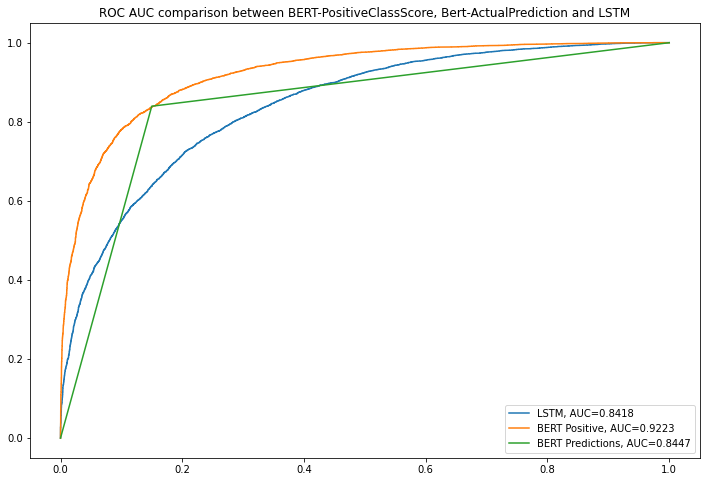

In [48]:


lstm_fpr, lstm_tpr, _ = roc_curve(lstm_true_vals, lstm_predictions_score, pos_label=label_dict['positive'])
bert_fpr, bert_tpr, _ = roc_curve(bert_true_vals, bert_predictions_score, pos_label=label_dict['positive'])
bert_pred_fpr, bert_pred_tpr, _ = roc_curve(bert_true_vals, bert_predictions, pos_label=label_dict['positive'])
lstm_auc = round(roc_auc_score(lstm_true_vals, lstm_predictions_score), 4)
bert_auc = round(roc_auc_score(bert_true_vals, bert_predictions_score), 4)
bert_pred_auc = round(roc_auc_score(bert_true_vals, bert_predictions), 4)
plt.figure(figsize=(12, 8))
plt.plot(lstm_fpr, lstm_tpr, label="LSTM, AUC="+str(lstm_auc))
plt.plot(bert_fpr, bert_tpr, label="BERT Positive, AUC="+str(bert_auc))
plt.plot(bert_pred_fpr, bert_pred_tpr, label="BERT Predictions, AUC="+str(bert_pred_auc))
plt.title("ROC AUC comparison between BERT-PositiveClassScore, Bert-ActualPrediction and LSTM")
plt.legend()

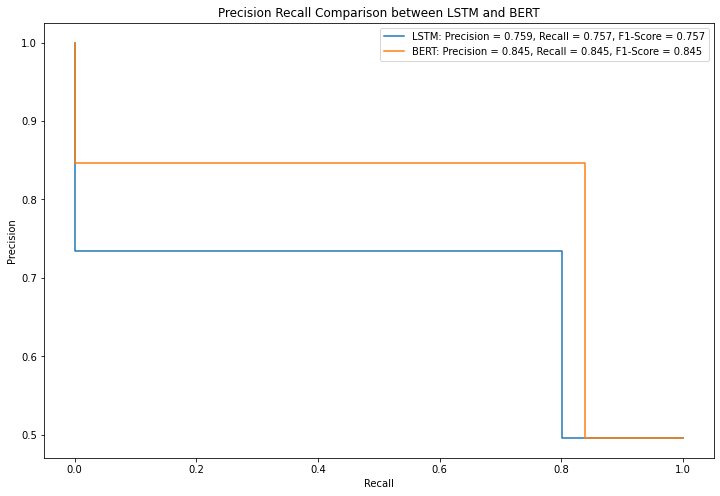

In [49]:
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import PrecisionRecallDisplay



# lstm_fpr, lstm_tpr, _ = roc_curve(lstm_true_vals, lstm_predictions_score, pos_label=label_dict['positive'])
lstm_prec, lstm_recall, _ = precision_recall_curve(lstm_true_vals, lstm_predictions, pos_label=label_dict['positive'])
lstm_prec_score = precision_score(lstm_true_vals, lstm_predictions, average='macro')
lstm_recall_score = recall_score(lstm_true_vals, lstm_predictions, average='macro')
bert_prec, bert_recall, _ = precision_recall_curve(bert_true_vals, bert_predictions, pos_label=label_dict['positive'])
bert_prec_score = precision_score(bert_true_vals, bert_predictions, average='macro')
bert_recall_score = recall_score(bert_true_vals, bert_predictions, average='macro')
lstm_label = "LSTM: Precision = {:.3f}, Recall = {:.3f}, F1-Score = {:.3f}".format(
    lstm_prec_score,
    lstm_recall_score,
    lstm_test_f1
)
bert_label = "BERT: Precision = {:.3f}, Recall = {:.3f}, F1-Score = {:.3f}".format(
    bert_prec_score,
    bert_recall_score,
    bert_test_f1
)
fig, ax = plt.subplots(figsize=(12, 8))
lstm_pr_display = PrecisionRecallDisplay(precision=lstm_prec, recall=lstm_recall).plot(label=lstm_label, ax=ax)
bert_pr_display = PrecisionRecallDisplay(precision=bert_prec, recall=bert_recall).plot(label=bert_label, ax=ax)
plt.title("Precision Recall Comparison between LSTM and BERT")
plt.legend()

Text(0.5, 1.0, 'LSTM Result Confusion Matrix')

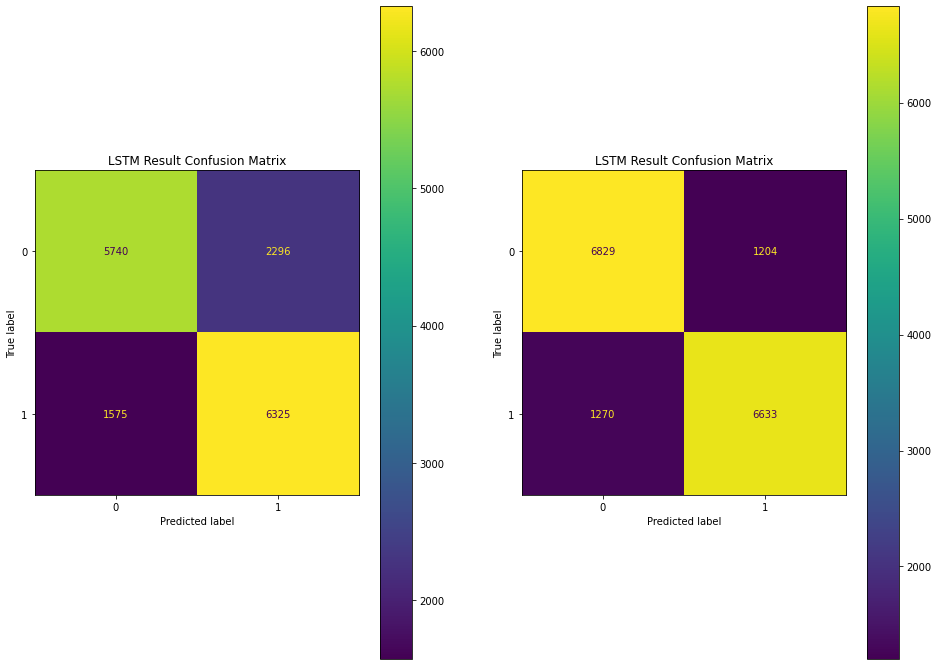

In [50]:


lstm_cm = confusion_matrix(lstm_true_vals, lstm_predictions, labels=[0, 1])
lstm_disp = ConfusionMatrixDisplay(confusion_matrix=lstm_cm, display_labels=[0, 1])
bert_cm = confusion_matrix(bert_true_vals, bert_predictions, labels=[0, 1])
bert_disp = ConfusionMatrixDisplay(confusion_matrix=bert_cm, display_labels=[0, 1])

fig, axes = plt.subplots(ncols=2, figsize=(16, 12))
lstm_disp.plot(ax=axes[0])
axes[0].set_title('LSTM Result Confusion Matrix')
bert_disp.plot(ax=axes[1])
axes[1].set_title('LSTM Result Confusion Matrix')


## Surface Architecture

printing out some architecture to for report and final layer of bert

In [51]:
lstm_model

SentimentLSTM(
  (embedding): Embedding(124575, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)

In [52]:
bert_model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element